'''
This dataset we will be exploring is focused on hospital readmissions, which is an important 
and costly issue for healthcare systems worldwide. Hospital readmissions occur when a patient
is discharged from a hospital, but then returns within a certain period of time, often due to 
complications or unresolved health issues.

By analysing the dataset, we hope to better understand the factors that contribute to hospital
readmissions and identify strategies to reduce their frequency. This information can be used to
improve patient outcomes, reduce healthcare costs, and enhance the overall quality of care provided
by hospitals.

'''

In [34]:
from scipy import stats as st
from imblearn.over_sampling import SMOTE
import numpy as np, pandas as pd, warnings
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict

warnings.filterwarnings('ignore')

In [35]:
df = pd.read_csv('C:\\Users\\Anyone\\Desktop\\readmitted.csv')

In [36]:
df.head()

,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,...,repaglinide,glipizide,insulin,count_No,count_Steady,count_Down,count_Up,change,diabetesMed,readmitted
0,1,Emergency,Discharged to home,Referral,1,41,0,1,0,0,...,No,No,No,4,0,0,0,No,No,NO
1,2,Emergency,Discharged to home,Emergency Room,3,59,0,18,0,0,...,No,No,Up,3,0,0,1,Ch,Yes,NO
2,3,Emergency,Discharged to home,Emergency Room,2,11,5,13,2,0,...,No,Steady,No,3,1,0,0,No,Yes,NO
3,4,Emergency,Discharged to home,Emergency Room,2,44,1,16,0,0,...,No,No,Up,3,0,0,1,Ch,Yes,NO
4,5,Emergency,Discharged to home,Emergency Room,1,51,0,8,0,0,...,No,Steady,Steady,2,2,0,0,Ch,Yes,NO


In [37]:
# Let's see if we have any duplicated rows

df.duplicated().sum()

2

In [38]:
# Now we gonna remove those two duplicated rows and then reset the index

df.drop_duplicates(inplace=True)
df.reset_index(drop=True,inplace=True)

In [39]:
# Do we have any missing values?

df.isnull().sum()

age                             0
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                          0
diag_2                          0
diag_3                          0
number_diagnoses                0
max_glu_serum               96418
A1Cresult                   84748
metformin                       0
repaglinide                     0
glipizide                       0
insulin                         0
count_No                        0
count_Steady                    0
count_Down                      0
count_Up                        0
change                          0
diabetesMed                     0
readmitted                      0
dtype: int64

In [40]:
# Looking at the datatypes of features to better understand the structure and content of the dataset.

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101764 entries, 0 to 101763
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   age                       101764 non-null  int64 
 1   admission_type_id         101764 non-null  object
 2   discharge_disposition_id  101764 non-null  object
 3   admission_source_id       101764 non-null  object
 4   time_in_hospital          101764 non-null  int64 
 5   num_lab_procedures        101764 non-null  int64 
 6   num_procedures            101764 non-null  int64 
 7   num_medications           101764 non-null  int64 
 8   number_outpatient         101764 non-null  int64 
 9   number_emergency          101764 non-null  int64 
 10  number_inpatient          101764 non-null  int64 
 11  diag_1                    101764 non-null  object
 12  diag_2                    101764 non-null  object
 13  diag_3                    101764 non-null  object
 14  numb

In [41]:
# Due to high number of missing values in the 'max_glu_serum' and 'A1Cresult' columns, 
# we have no choice but to remove them.

df.drop(['max_glu_serum','A1Cresult'],axis=1,inplace=True)

In [42]:
# Printing the unique values and their counts for each feature.

for i in df.columns:
    print('\n---------------\n', df[i].value_counts(), '\n---------------\n')


---------------
 age
8     26068
7     22483
6     17256
9     17197
5      9685
4      3775
10     2793
3      1657
2       690
1       160
Name: count, dtype: int64 
---------------


---------------
 admission_type_id
Emergency    64405
Elective     18869
Urgent       18480
Newborn         10
Name: count, dtype: int64 
---------------


---------------
 discharge_disposition_id
Discharged to home        64912
Discharged/Transferred    34429
Expired                    1652
Hospice                     771
Name: count, dtype: int64 
---------------


---------------
 admission_source_id
Emergency Room    57778
Referral          30856
Transfer          13109
Others               21
Name: count, dtype: int64 
---------------


---------------
 time_in_hospital
3     17755
2     17223
1     14208
4     13924
5      9966
6      7539
7      5859
8      4391
9      3002
10     2342
11     1855
12     1448
13     1210
14     1042
Name: count, dtype: int64 
---------------


---------------
 

<Axes: xlabel='glipizide', ylabel='count'>

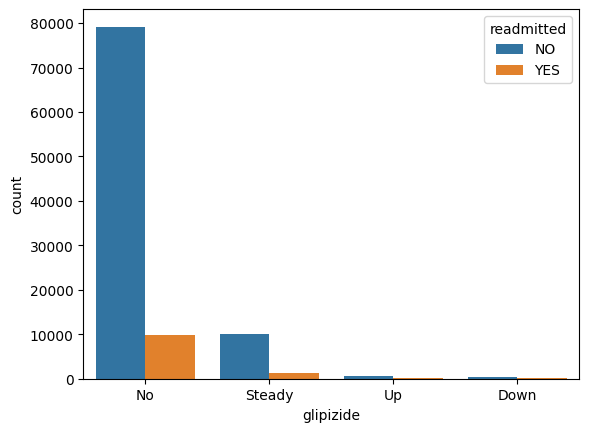

In [43]:
# This feature is imbalanced but I'm not thinking of removing it yet, because our 
# target variable is imbalanced as well. We will resample the dataset.

sns.countplot(x=df['glipizide'],hue=df['readmitted'])

<Axes: xlabel='repaglinide', ylabel='count'>

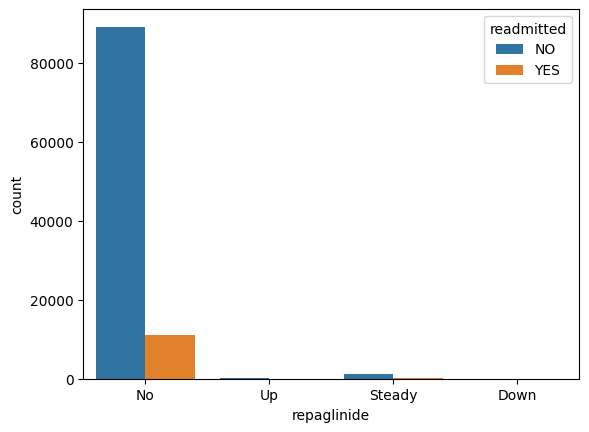

In [44]:
# This feature has four unique values, but one of those unique values has more than 95% of 
# the total values of this column. We gonna get rid of it soon.

sns.countplot(x=df['repaglinide'],hue=df['readmitted'])

In [45]:
# Here we are Label Encoding categorical variables

df['admission_type_id'] = LabelEncoder().fit_transform(df['admission_type_id'])
df['discharge_disposition_id'] = LabelEncoder().fit_transform(df['discharge_disposition_id'])
df['admission_source_id'] = LabelEncoder().fit_transform(df['admission_source_id'])
df['diag_1'] = LabelEncoder().fit_transform(df['diag_1'])
df['diag_2'] = LabelEncoder().fit_transform(df['diag_2'])
df['diag_3'] = LabelEncoder().fit_transform(df['diag_3'])
df['metformin'] = LabelEncoder().fit_transform(df['metformin'])
df['glipizide'] = LabelEncoder().fit_transform(df['glipizide'])
df['repaglinide'] = LabelEncoder().fit_transform(df['repaglinide'])
df['insulin'] = LabelEncoder().fit_transform(df['insulin'])
df['change'] = LabelEncoder().fit_transform(df['change'])
df['diabetesMed'] = LabelEncoder().fit_transform(df['diabetesMed'])
df['readmitted'] = LabelEncoder().fit_transform(df['readmitted'])

<Axes: >

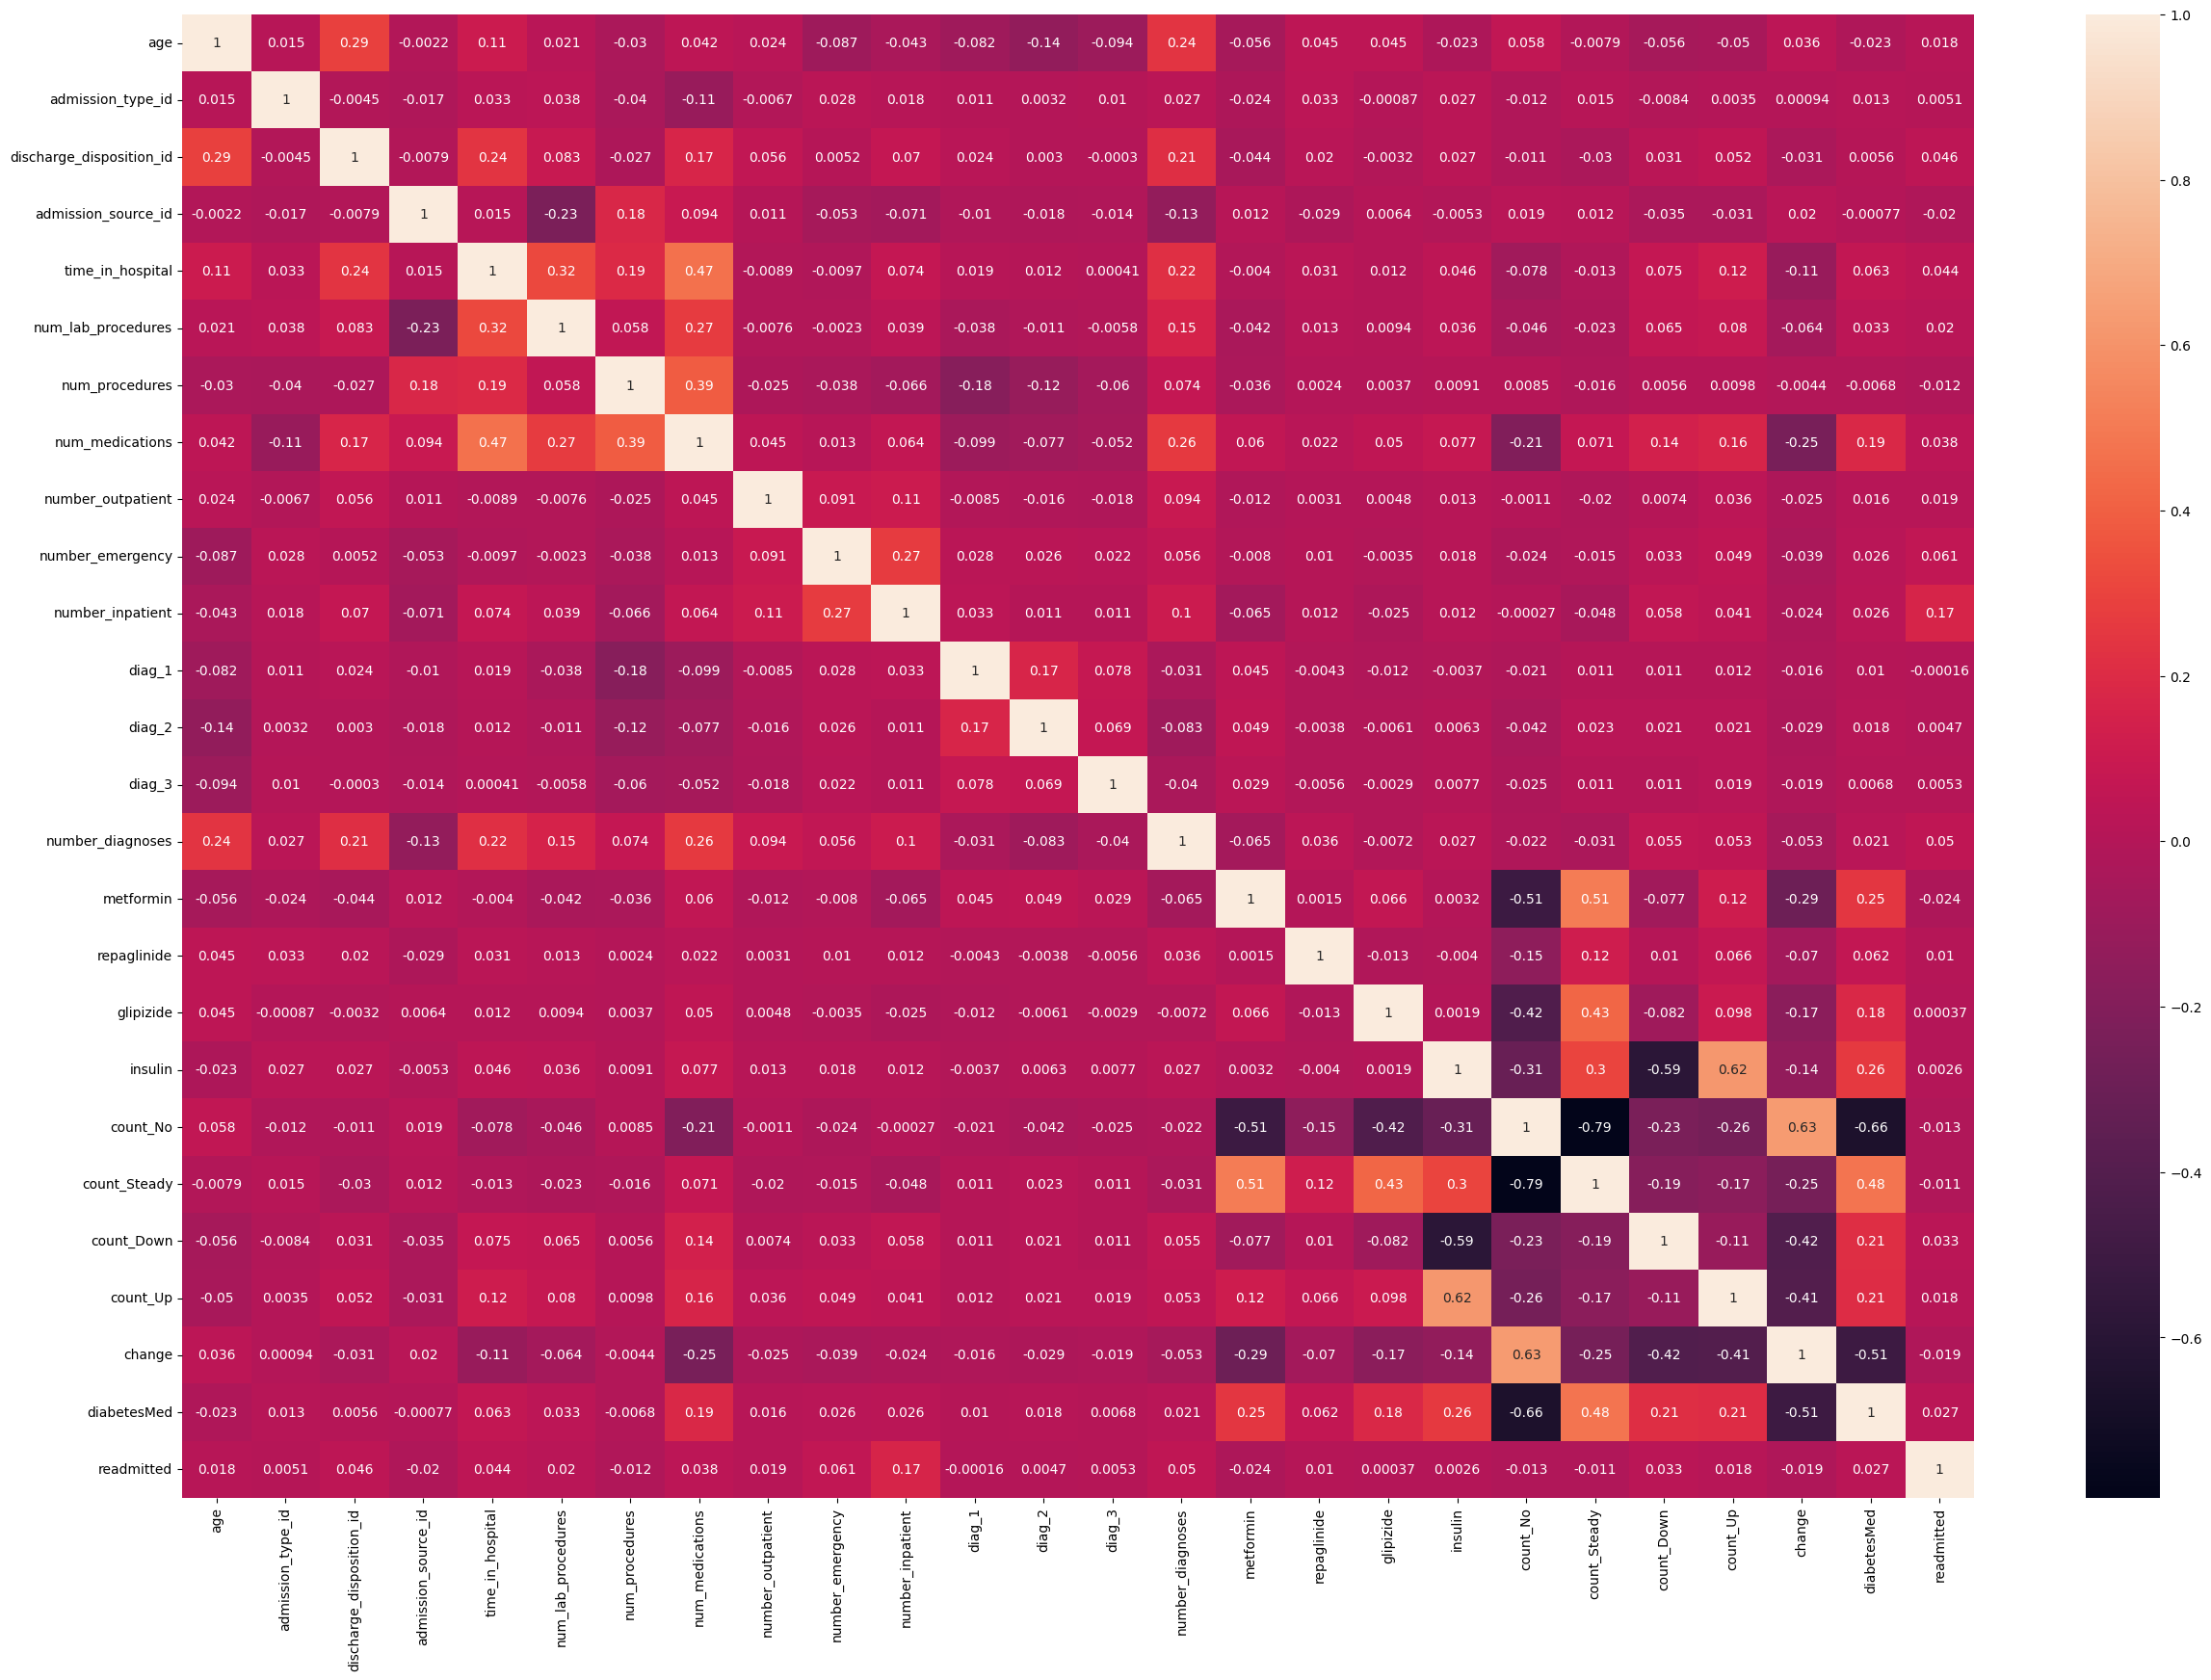

In [46]:
# Visualizing correlations between features.

plt.figure(figsize=(30,20))
sns.heatmap(df.corr(), annot=True)

In [47]:
# In this cell, I'm eliminating some features that either have a weak correlation with the
# target variable or have a high correlation with another feature. For instance, the features 'metformin'
# and 'count_Steady' are correlated, but I'm removing 'count_Steady' because it has a weaker correlation
# with the target variable.

df.drop(['admission_type_id','diag_1','diag_2','diag_3','glipizide','insulin',
         'count_No','change','count_Steady','repaglinide'], axis=1, inplace=True)

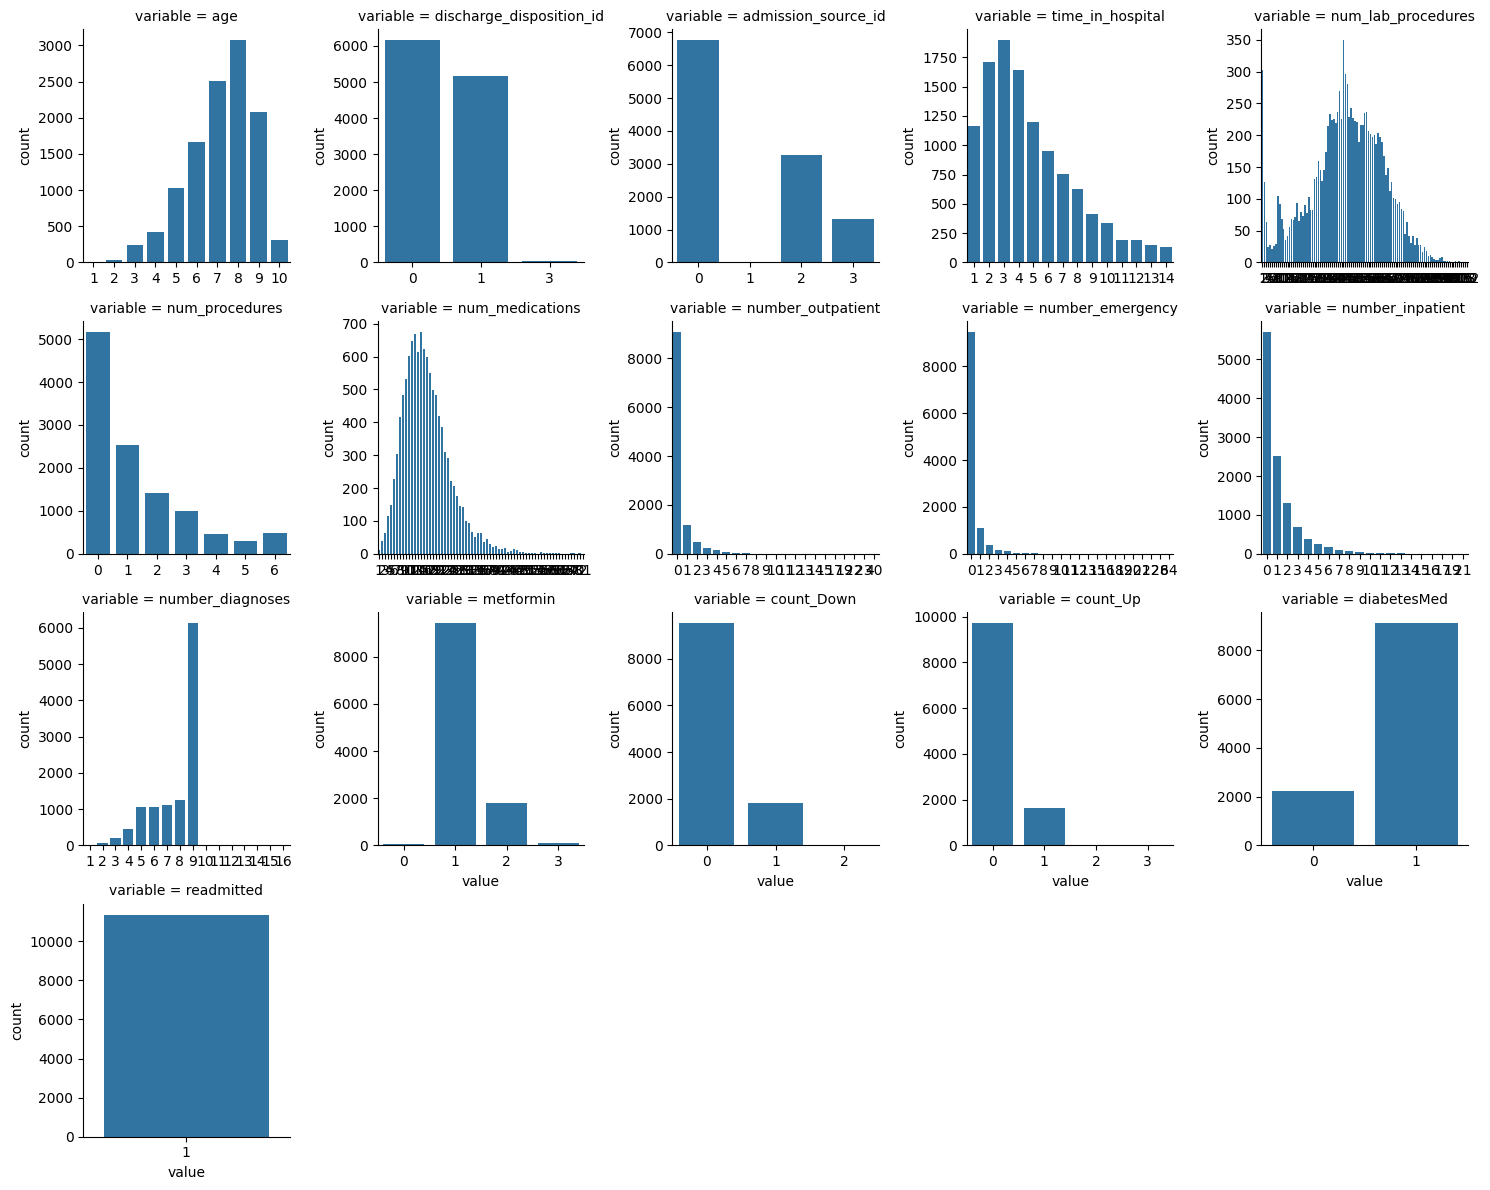

In [48]:
# These charts show the counts of readmitted patients grouped by the features of our dataset.
# By looking at the countplot of 'age' variable, we can see that people aged 70-80
# are more likely to be readmitted

sns.FacetGrid(df[df['readmitted'] == 1].melt(), col='variable', col_wrap=5, sharex=False, sharey=False).map(sns.countplot, 'value')

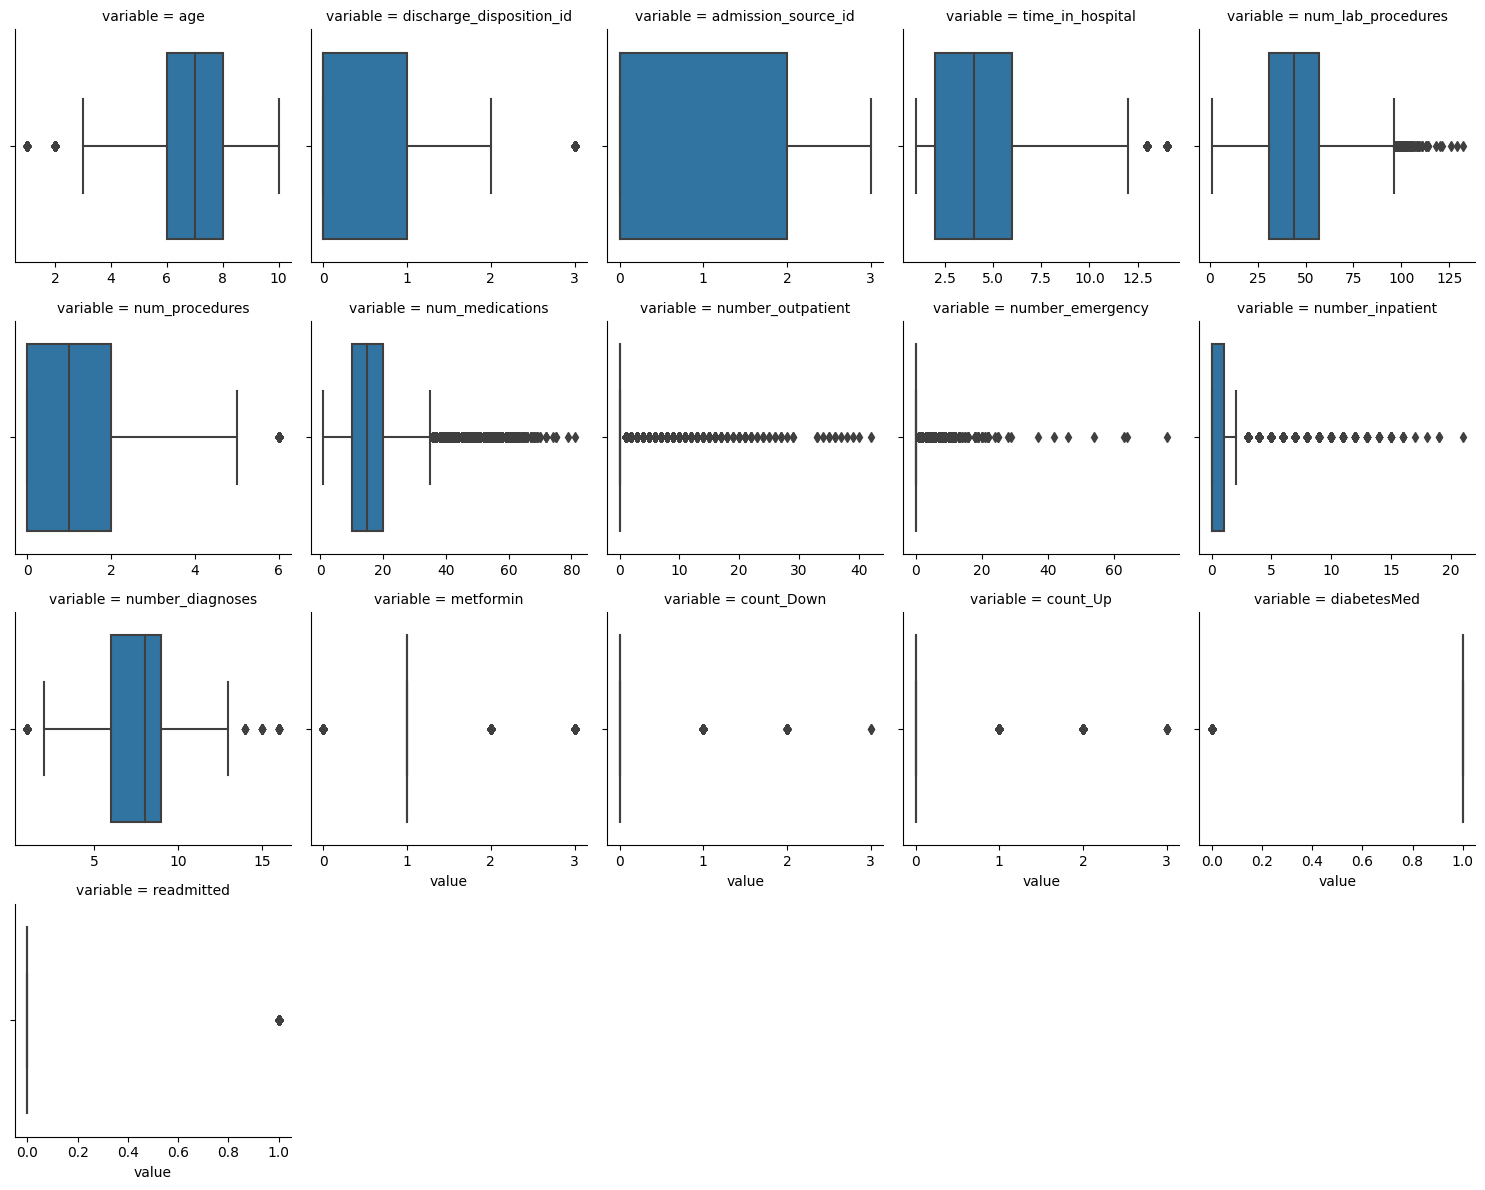

In [49]:
# Seaborn's Boxplots are now gonna show us if we have any outliers.

sns.FacetGrid(df.melt(), col='variable', col_wrap=5, sharex=False, sharey=False).map(sns.boxplot, 'value')

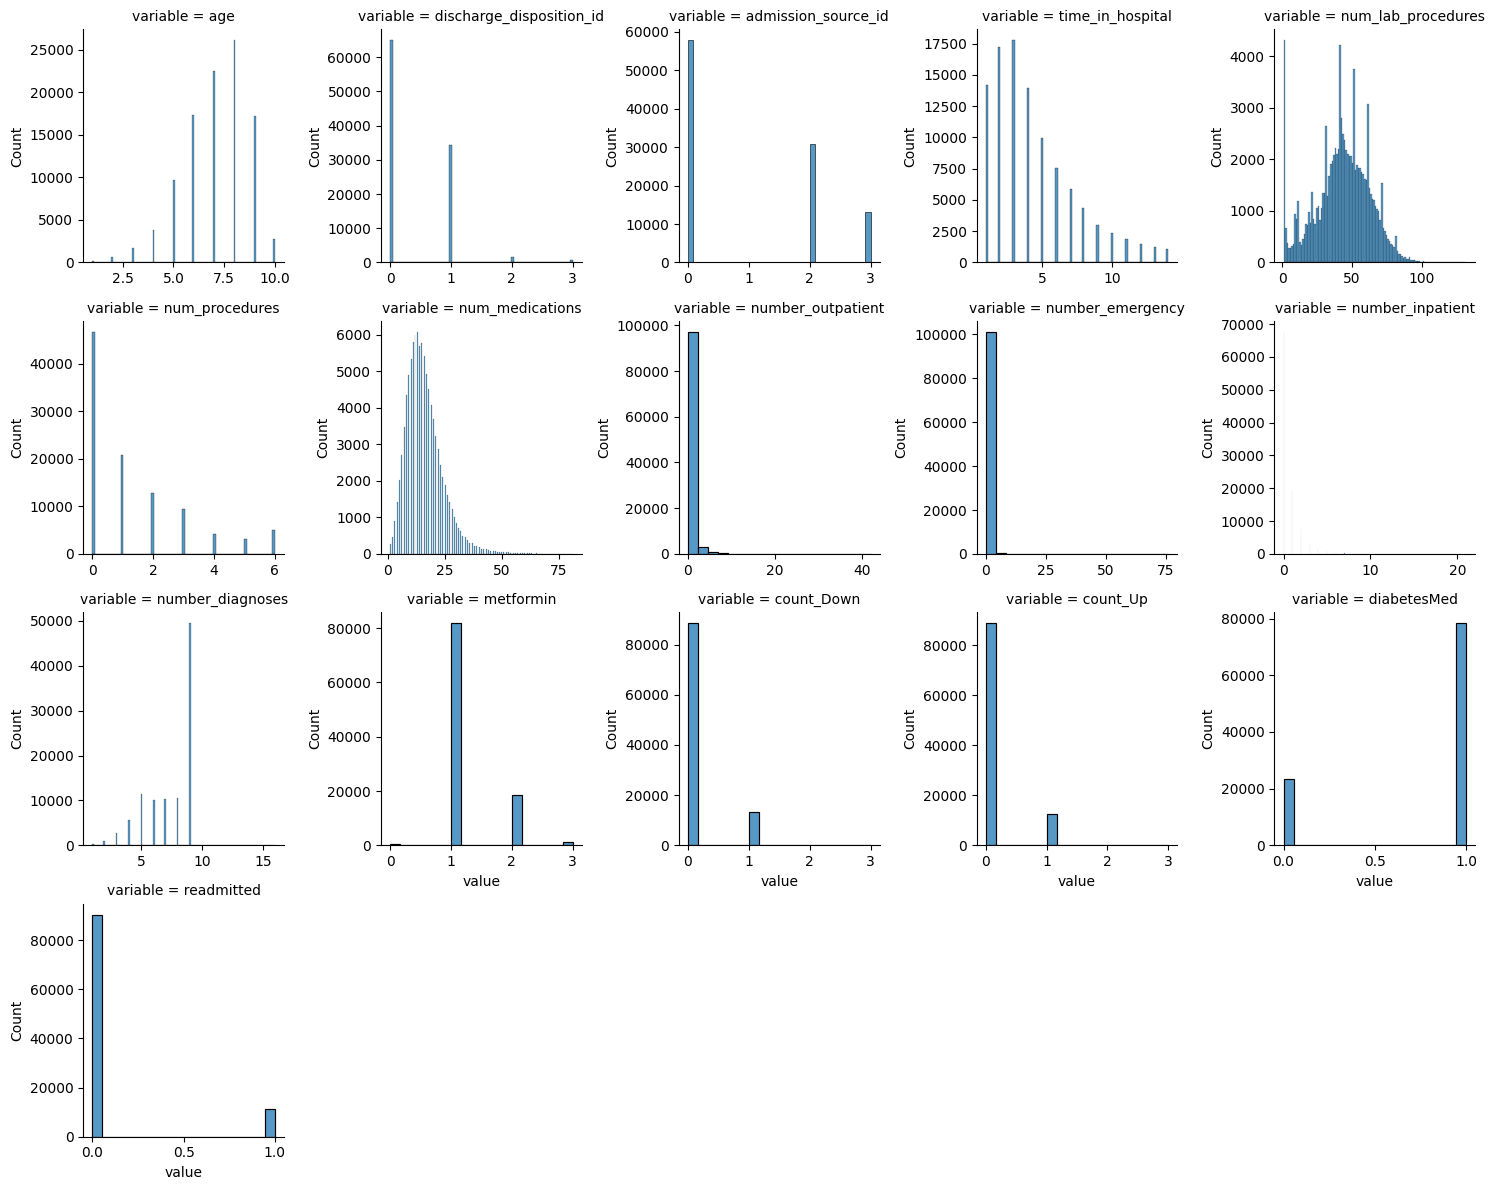

In [50]:
# Histograms tell us almost everything about the data.

sns.FacetGrid(df.melt(), col='variable', col_wrap=5, sharex=False, sharey=False).map(sns.histplot, 'value')

In [51]:
# Let's apply log transformation to 'num_medications'

df['num_medications'] = np.log(df['num_medications'])

<Axes: xlabel='num_medications', ylabel='Count'>

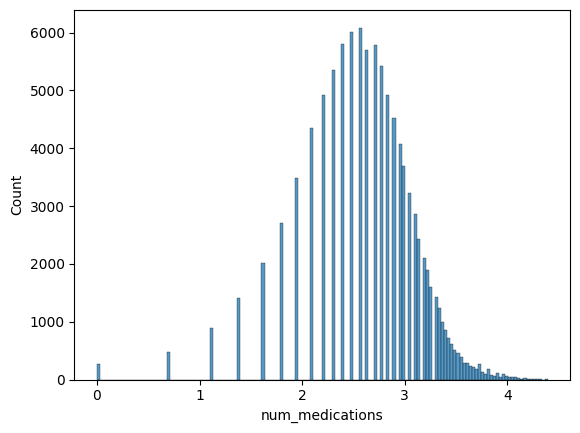

In [52]:
# 'num_medications' after log transformation

sns.histplot(df['num_medications'])

In [53]:
# Pandas' Describe function helps us find outliers. Just look at the 'num_lab_procedures' column.
# The value at 99% is 85, but the maximum is 132.

df.describe([0.01,0.1,0.25,0.75,0.9,0.99]).T

,count,mean,std,min,1%,10%,25%,50%,75%,90%,99%,max
age,101764.0,7.096812,1.593905,1.0,3.000000,5.00000,6.000000,7.00000,8.000000,9.000000,10.0000,10.000000
discharge_disposition_id,101764.0,0.393518,0.562663,0.0,0.000000,0.00000,0.000000,0.00000,1.000000,1.000000,2.0000,3.000000
admission_source_id,101764.0,0.993082,1.177375,0.0,0.000000,0.00000,0.000000,0.00000,2.000000,3.000000,3.0000,3.000000
time_in_hospital,101764.0,4.396024,2.985124,1.0,1.000000,1.00000,2.000000,4.00000,6.000000,9.000000,14.0000,14.000000
num_lab_procedures,101764.0,43.095535,19.674538,1.0,1.000000,14.00000,31.000000,44.00000,57.000000,67.000000,85.0000,132.000000
num_procedures,101764.0,1.339757,1.705813,0.0,0.000000,0.00000,0.000000,1.00000,2.000000,4.000000,6.0000,6.000000
num_medications,101764.0,2.642970,0.539405,0.0,1.098612,1.94591,2.302585,2.70805,2.995732,3.258097,3.7612,4.394449
number_outpatient,101764.0,0.369364,1.267276,0.0,0.000000,0.00000,0.000000,0.00000,0.000000,1.000000,5.0000,42.000000
number_emergency,101764.0,0.197840,0.930481,0.0,0.000000,0.00000,0.000000,0.00000,0.000000,1.000000,3.0000,76.000000
number_inpatient,101764.0,0.635578,1.262873,0.0,0.000000,0.00000,0.000000,0.00000,1.000000,2.000000,6.0000,21.000000


In [54]:
# Removing outliers using zscore from scipy.
# To calculate Z score you need to subtract the value from the mean and 
# divide the result by the standard deviation

# For example, the first line of code will remove data points in 'age' column that are 3 standard
# deviations away from the mean and are on the left side of the distribution.

df = df[~(st.zscore(df['age']) < -3)]
df = df[~(st.zscore(df['discharge_disposition_id']) > 3)]
df = df[~(st.zscore(df['time_in_hospital']) > 2.9)]
df = df[~(st.zscore(df['num_lab_procedures']) > 2.4)]
df = df[~(st.zscore(df['num_medications']) > 2.6)]
df = df[~(st.zscore(df['num_medications']) < -3.5)]
df = df[~(st.zscore(df['number_outpatient']) > 4.5)]
df = df[~(st.zscore(df['number_inpatient']) > 4.5)]
df = df[~(st.zscore(df['number_emergency']) > 4.5)]
df = df[~(st.zscore(df['number_diagnoses']) > 2.5)]
df = df[~(st.zscore(df['number_diagnoses']) < -3.3)]
df = df[~(st.zscore(df['count_Down']) > 3.5)]
df = df[~(st.zscore(df['count_Up']) > 3.5)]

In [55]:
# After removing outliers, we have lost some rows. So we need to reset the index

df.reset_index(drop=True,inplace=True)

In [56]:
# As our dataset is imbalanced, we need to use some resampling techniques.
# First, I will upsample the minority class, but I will use 0.5 for sampling_strategy
# parameter, which means the minority class will be half of the majority class. 
# And then I will downsample the majority class to make it equal to the minority class.

X = df.drop('readmitted',axis=1)
y = df['readmitted']

X_sampled, y_sampled = SMOTE(sampling_strategy=0.5).fit_resample(X,y)
X_sampled, y_sampled = RandomUnderSampler().fit_resample(X_sampled,y_sampled)

In [57]:
# Finnaly we have a balanced dataset

y_sampled.value_counts()

readmitted
0    42545
1    42545
Name: count, dtype: int64

In [58]:
# Splitting the dataset into training and testing sets.
# Also scaling the dataset using MinMaxScaler from sklearn.

X_train, X_test, y_train, y_test = train_test_split(X_sampled,y_sampled, test_size=0.2)

X_train_scaled = MinMaxScaler().fit_transform(X_train)
X_test_scaled = MinMaxScaler().fit_transform(X_test)

In [59]:
# Training and testing with Random Forest
# I've also tried some other algorithms on this data, but this one had the highest score.

rf1 = RandomForestClassifier()
rf1.fit(X_train_scaled,y_train)
y_pred = rf1.predict(X_test_scaled)

print(f"\nAccuracy: {accuracy_score(y_test,y_pred)*100:.2f}%\n")
print("--"*30)
print(f"\n{classification_report(y_test,y_pred)}")
print("--"*30)
print(f"\n{confusion_matrix(y_test,y_pred)}")


Accuracy: 79.59%

------------------------------------------------------------

              precision    recall  f1-score   support

           0       0.79      0.81      0.80      8572
           1       0.80      0.79      0.79      8446

    accuracy                           0.80     17018
   macro avg       0.80      0.80      0.80     17018
weighted avg       0.80      0.80      0.80     17018

------------------------------------------------------------

[[6909 1663]
 [1810 6636]]


In [60]:
# Sometimes we might get better results without balancing and scaling the dataset.
# The outcome of this cell shows us that the accuracy is higher(88.61%) than the previous one.
# But if you look at the classification report, you can see that the model
# is able to classify only the majority class.

xtrain, xtest, ytrain, ytest = train_test_split(X,y, test_size=0.2)

rf2 = RandomForestClassifier()
rf2.fit(xtrain,ytrain)
ypred = rf2.predict(xtest)

print(f"\nAccuracy: {accuracy_score(ytest,ypred)*100:.2f}%\n")
print("--"*30)
print(f"\n{classification_report(ytest,ypred)}")
print("--"*30)
print(f"\n{confusion_matrix(ytest,ypred)}")


Accuracy: 88.96%

------------------------------------------------------------

              precision    recall  f1-score   support

           0       0.89      1.00      0.94     17026
           1       0.19      0.00      0.01      2089

    accuracy                           0.89     19115
   macro avg       0.54      0.50      0.47     19115
weighted avg       0.81      0.89      0.84     19115

------------------------------------------------------------

[[16997    29]
 [ 2082     7]]


In [61]:
# We need to perform cross-validation on our imbalanced dataset

rf3 = RandomForestClassifier()
cv = cross_val_score(rf3, X, y, error_score="raise", cv=5, n_jobs=-1)
print(cv)

[0.8893016  0.88966203 0.8892958  0.88777859 0.88887726]


In [62]:
# Printing accuracy and classification report for each fold of cross validation.
# The outcome of this cell shows that none of the folds performed well

y_pred = cross_val_predict(rf3, X, y, cv=5, n_jobs=-1)

for i in range(5):
    start = i * len(y) // 5
    end = (i+1) * len(y) // 5
    
    print(f"\n Accuracy: {accuracy_score(y[start:end], y_pred[start:end])}\n\n")
    print("--"*30)
    print(f"\n{classification_report(y[start:end], y_pred[start:end])}\n")
    print("--"*30)


 Accuracy: 0.8843256251961913


------------------------------------------------------------

              precision    recall  f1-score   support

           0       0.89      1.00      0.94     16922
           1       0.15      0.00      0.00      2192

    accuracy                           0.88     19114
   macro avg       0.52      0.50      0.47     19114
weighted avg       0.80      0.88      0.83     19114


------------------------------------------------------------

 Accuracy: 0.889609710160092


------------------------------------------------------------

              precision    recall  f1-score   support

           0       0.89      1.00      0.94     17014
           1       0.29      0.00      0.01      2100

    accuracy                           0.89     19114
   macro avg       0.59      0.50      0.47     19114
weighted avg       0.82      0.89      0.84     19114


------------------------------------------------------------

 Accuracy: 0.8841686721774615


